<a href="https://colab.research.google.com/github/gandhimonil9823/CS_GO_Analysis/blob/main/Smoke_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import model_selection
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans


In [2]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount(r'drive/folders/0AAxMXLC9WPNxUk9PVA')


Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [4]:
cd 'drive/Shared drives/CS_GO_Data/processed_data_v2'

/content/drive/Shared drives/CS_GO_Data/processed_data_v2


In [5]:
ls

aggregated_data/  de_nuke.png       mm_grenades_demos.csv
cs_cruise.png     de_overpass.png   out-de_cache.png
damage_data.csv   de_royal.png      out-de_cbble.png
de_cache.png      de_santorini.png  out-de_dust2.png
de_cbble.png      de_season.png     out-de_inferno.png
de_coast.png      de_train.png      out-de_mirage.png
de_dust2.png      de_tulip.png      out-de_overpass.png
de_empire.png     grenade_data.csv  out-de_train.png
de_inferno.png    kill_data.csv     winnerSide_matches.csv
de_mikla.png      Log_ROC.png       winnerSide_rounds.csv
de_mirage.png     map_data.csv      winnerSide_teams.csv
de_new_nuke.png   meta_data.csv


# Smoke Plot for Maps and Attack_Sides (CT or T) 

In [9]:
# def pointx_to_resolutionx(xinput,startX=-3217,endX=1912,resX=1024):
def x_point_convert(xin,X_start,X_end,X_resolution=1024):

    size_X= X_end-X_start
    if X_start < 0:
        xin += X_start *(-1.0)
    else:
        xin += X_start
    xout = float((xin / abs(size_X)) * X_resolution);
    return xout

def y_point_convert(yin,Y_start,Y_end,Y_resolution=1024):
    size_Y=Y_end-Y_start
    if Y_start < 0:
        yin += Y_start *(-1.0)
    else:
        yin += Y_start
    yout = float((yin / abs(size_Y)) * Y_resolution);
    return Y_resolution-yout


def plot_map_smoke(df_preprocessed_map_ct_t, map):
  im = plt.imread(map + ".png")
  print(map + ".png")
  plt.figure(figsize=(15,15))
  t = plt.imshow(im)
  # BLUE - Grenade Position
  t = plt.scatter(df_preprocessed_map_ct_t['nade_xpos'], df_preprocessed_map_ct_t['nade_ypos'],alpha=0.05,c='blue')

  # RED - throwing position
  t = plt.scatter(df_preprocessed_map_ct_t['thrower_xpos'], df_preprocessed_map_ct_t['thrower_ypos'],alpha=0.05,c='red')


def preprocess_data(df_grende_data, map, att_side):
  df_preprocessed_map_ct_t = df_grende_data.loc[((df_grende_data["nade"]== "Smoke") & (df_grende_data["map"]==map) & (df_grende_data["att_side"] == att_side))]

  # print(df_preprocessed_map_ct_t)

  df_preprocessed_map_ct_t = df_preprocessed_map_ct_t[[ 'nade_land_x', 'nade_land_y', 'att_rank', 'att_pos_x', 'att_pos_y']]

  df_preprocessed_map_ct_t = df_preprocessed_map_ct_t.dropna()

  return df_preprocessed_map_ct_t

# Function takes in a map and the att_side = Terr or Counterr
def smoke_map_t_ct(map, att_side):

  df_grende_data = pd.read_csv("mm_grenades_demos.csv")

  map_df = pd.read_csv('map_data.csv')
  map_df.rename(columns={'Unnamed: 0':'map'}, inplace=True)
  map_df.set_index('map', inplace=True)

  mp = map_df.loc[map]
  Start_X = [mp['StartX'], mp['EndX']]
  Start_Y = [mp['StartY'], mp['EndY']]

  df_preprocessed_map_ct_t = preprocess_data(df_grende_data, map, att_side)

  # convert x,y in game coordinates to coordinates on an image
  df_preprocessed_map_ct_t['thrower_xpos']=[x_point_convert(row['att_pos_x'], Start_X[0], Start_X[1]) for index, row in df_preprocessed_map_ct_t.iterrows()]
  df_preprocessed_map_ct_t['thrower_ypos']= [y_point_convert(row['att_pos_y'], Start_Y[0], Start_Y[1]) for index, row in df_preprocessed_map_ct_t.iterrows()]
  df_preprocessed_map_ct_t['nade_ypos'] = [y_point_convert(row['nade_land_y'], Start_Y[0], Start_Y[1]) for index, row in df_preprocessed_map_ct_t.iterrows()]
  df_preprocessed_map_ct_t['nade_xpos'] = [x_point_convert(row['nade_land_x'], Start_X[0], Start_X[1]) for index, row in df_preprocessed_map_ct_t.iterrows()]

  plot_map_smoke(df_preprocessed_map_ct_t, str(map))

  return df_preprocessed_map_ct_t


de_mirage.png


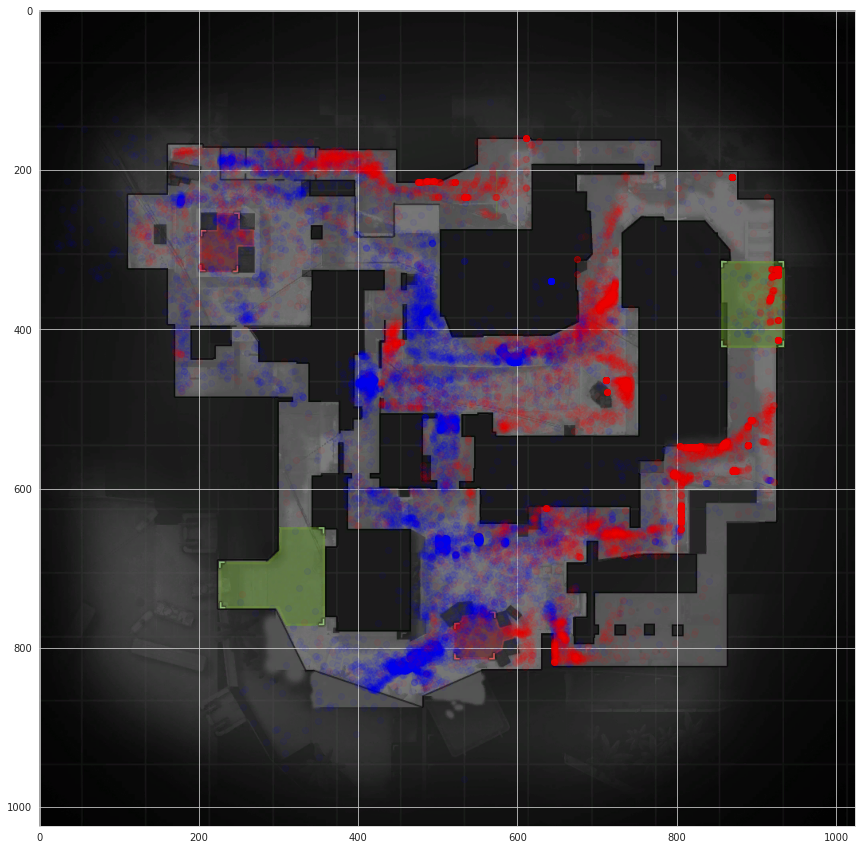

In [10]:

# map name and att_side = T or CT for all the maps in the map.csv
df_map_ct_t_values = smoke_map_t_ct("de_mirage", "Terrorist")

# Smoke Plot for Maps and Attack_Sides (CT or T) based on Density

In [11]:
def plot_density_based(df_map_ct_t_values, series_bollean_density, map):
  im = plt.imread(map)
  plt.figure(figsize=(12,12))
  implot = plt.imshow(im)
  implot = plt.scatter(df_map_ct_t_values['thrower_xpos'][series_bollean_density], df_map_ct_t_values['thrower_ypos'][series_bollean_density],alpha=0.15
                      ,c='red',s=5) 
  implot = plt.scatter(df_map_ct_t_values['nade_xpos'][series_bollean_density], df_map_ct_t_values['nade_ypos'][series_bollean_density],alpha=0.15
                      ,c='blue',s=5) 

def calc_N_Nearby(x,y,x_col_arr,y_col_arr,density_val):
    value_array=[(x_col_arr < (x + density_val)) & (x_col_arr > (x - density_val)) & (y_col_arr < (y + density_val)) & (y_col_arr > (y - density_val))][0]
    return len(x_col_arr[value_array])

density_based_values = []
def smoke_plot_density_based(df_map_ct_t_values, density_val, map):
  for index, row in df_map_ct_t_values.iterrows():
    thrower_xpos = row['thrower_xpos']
    thrower_ypos = row['thrower_ypos']
    return_value_den = calc_N_Nearby(thrower_xpos, thrower_ypos, df_map_ct_t_values['thrower_xpos'], df_map_ct_t_values['thrower_ypos'], density_val)
    density_based_values.append(return_value_den)

  df_map_ct_t_values['density'] = density_based_values

  series_bollean_density =[(df_map_ct_t_values['density'] > 100)][0]

  plot_density_based(df_map_ct_t_values, series_bollean_density, map)

  return df_map_ct_t_values




nade_land_x  nade_land_y  att_rank  ...   nade_ypos   nade_xpos  density
1683    -792.502800    -851.0277        16  ...  510.293206  484.048573      250
1684    -798.543500    -896.3890        13  ...  519.431504  482.842553      152
1687      -6.300833   -1540.7100        15  ...  649.233728  641.013053     1218
1688    -662.862400     531.9008        16  ...  231.694193  509.931157       24
1690    -672.922100   -1304.0330        13  ...  601.553766  507.922747       32
...             ...          ...       ...  ...         ...         ...      ...
364998 -1562.804000     671.7926        11  ...  203.512173  330.258667      100
365033 -1482.800000     760.8912        11  ...  185.562741  346.231390      174
365074  -155.836900   -1686.6630        11  ...  678.636811  611.158318      229
365079   192.870700    -267.7387         0  ...  392.786234  680.777461       82
365099   453.129500   -1601.1850         0  ...  661.416770  732.737884      233

[14805 rows x 10 columns]

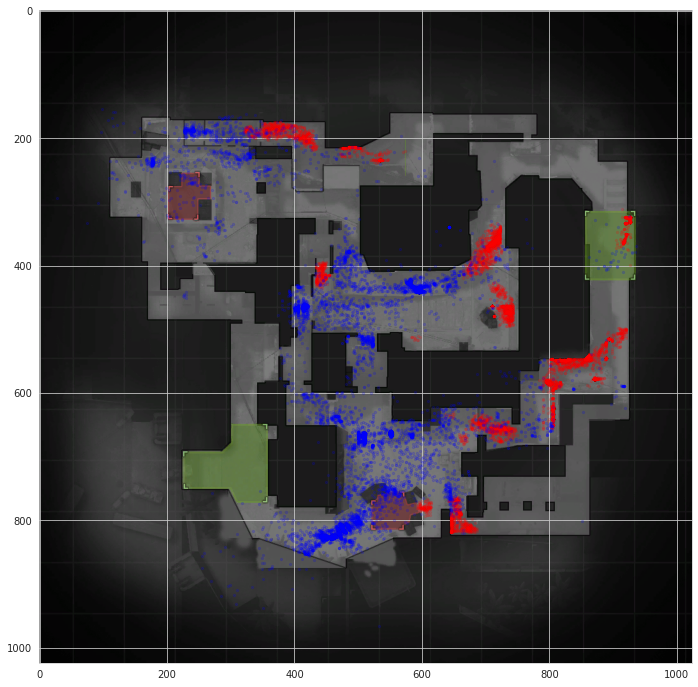

In [12]:
df_density_based_plot_values = smoke_plot_density_based(df_map_ct_t_values, 15, "de_mirage.png")

df_density_based_plot_values

# K Means Clustering on the Smoke Plot

In [17]:
def fit_k_means(df_density_based_plot_values, map):
  k_means_clustering = KMeans(n_clusters=25) 
  series_bollean_density =[(df_density_based_plot_values['density'] > 100)][0]
  k_means_clustering.fit(df_density_based_plot_values[["thrower_xpos","thrower_ypos"]][series_bollean_density])
  c_centers=pd.DataFrame(k_means_clustering.cluster_centers_)
  plot_centers_clusters(df_density_based_plot_values, c_centers, series_bollean_density, map)
  return k_means_clustering


def plot_centers_clusters(df_density_based_plot_values, center_clusters, series_bollean_density, map):
  im = plt.imread(map)
  plt.figure(figsize=(12,12))
  implot = plt.imshow(im)
  implot = plt.scatter(df_density_based_plot_values['thrower_xpos'][series_bollean_density], df_density_based_plot_values['thrower_ypos'][series_bollean_density],alpha=0.25, c='red',s=5) 
  implot = plt.scatter(df_density_based_plot_values['nade_xpos'][series_bollean_density], df_density_based_plot_values['nade_ypos'][series_bollean_density],alpha=0.25, c='blue',s=5) 
  implot = plt.scatter(center_clusters[0],center_clusters[1],alpha=1.0, c='white',s=35)


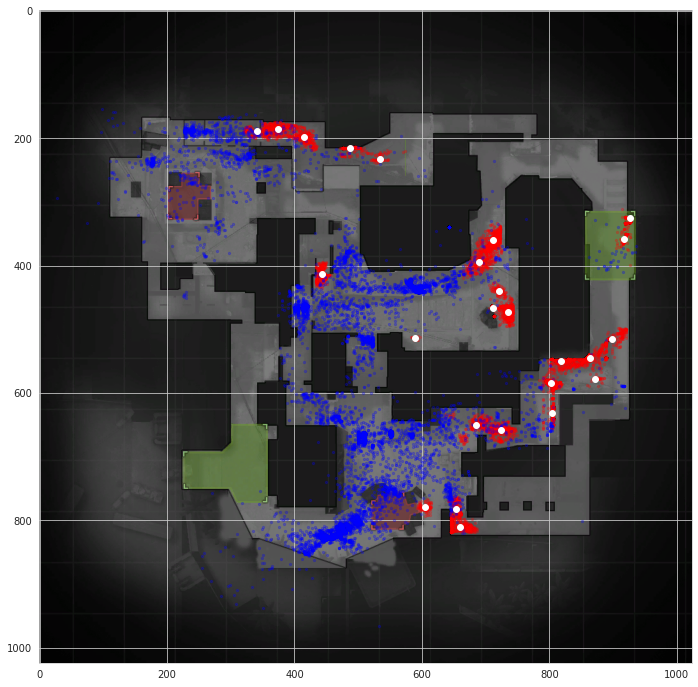

In [18]:
# For calling fit_k_means provide the previous run dataframe with the density column and a map name 
k_means_clustering = fit_k_means(df_density_based_plot_values, "de_mirage.png")

# Cluster Plot for the label values of the Clusters

In [20]:
def return_df_unlabel_data(df_density_based_plot_values, kmeans):
  series_bollean_density =[(df_density_based_plot_values['density'] > 100)][0]
  df_density_based_plot_values['kmeanslabel']=np.zeros(len(series_bollean_density))
  df_density_based_plot_values['kmeanslabel'][series_bollean_density]=kmeans.labels_
  return df_density_based_plot_values

def plot_individual_clusters(df_density_based_plot_values ,map, range_cluster):
  for i in range(1,range_cluster):
    index_i=[df_density_based_plot_values['kmeanslabel'] == i][0]
    im = plt.imread(map)
    plt.figure(figsize=(8,8))
    implot = plt.imshow(im)
    implot = plt.scatter(df_density_based_plot_values['thrower_xpos'][index_i], df_density_based_plot_values['thrower_ypos'][index_i],alpha=0.25
                         ,c='red',s=5) 
    implot = plt.scatter(df_density_based_plot_values['nade_xpos'][index_i], df_density_based_plot_values['nade_ypos'][index_i],alpha=0.25
                         ,c='blue',s=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To contr

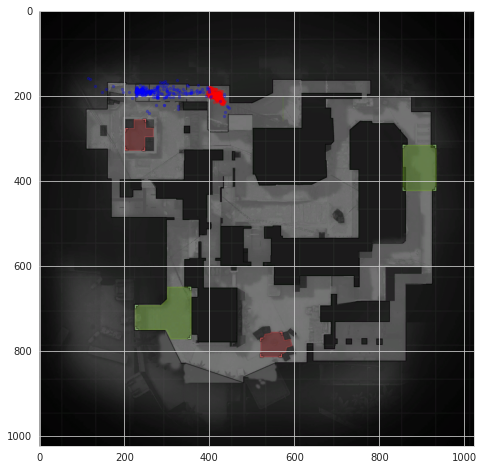

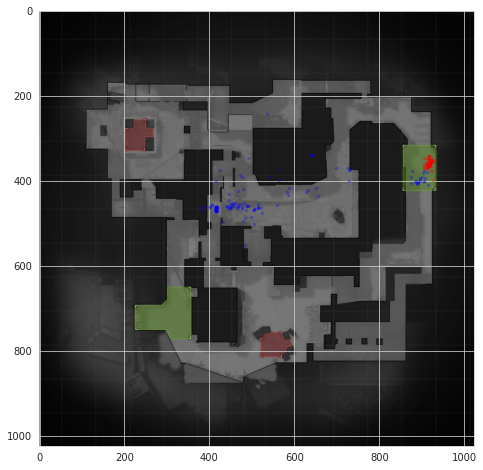

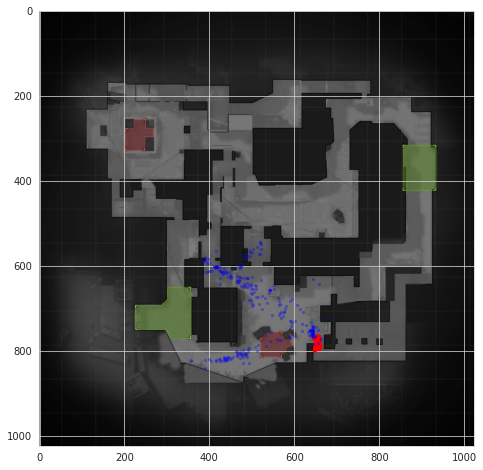

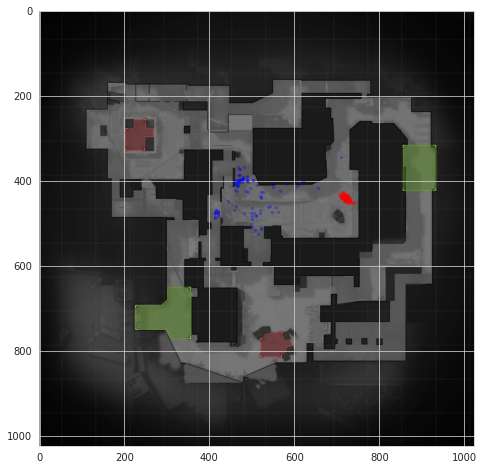

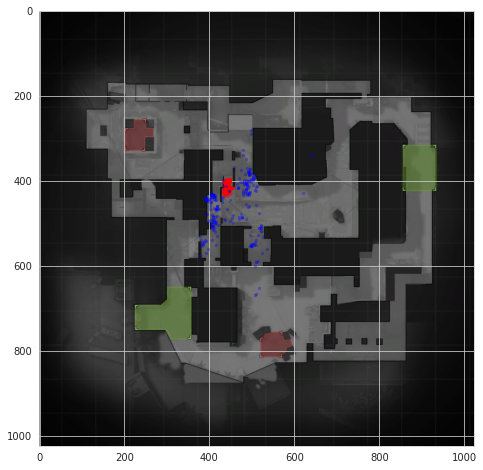

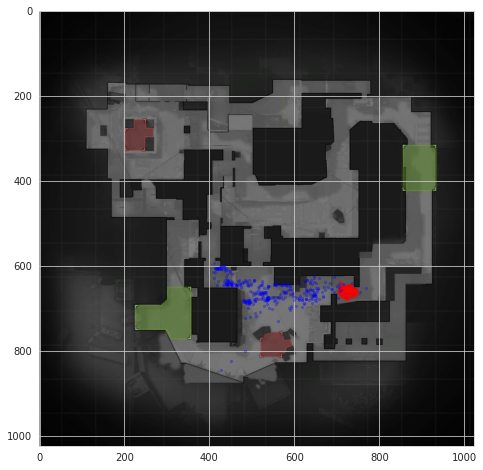

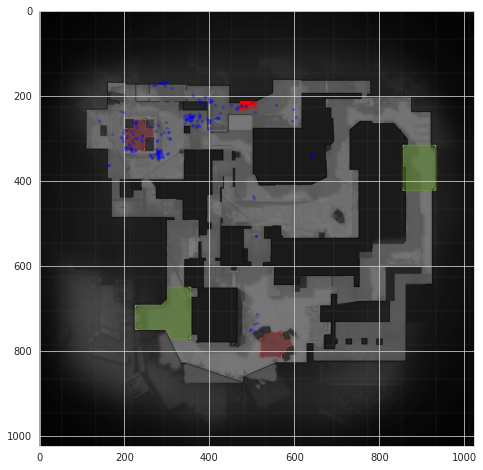

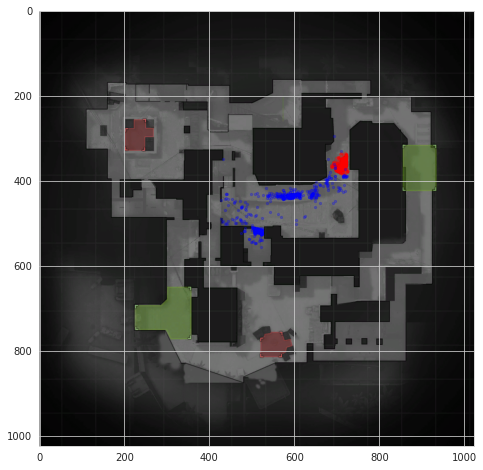

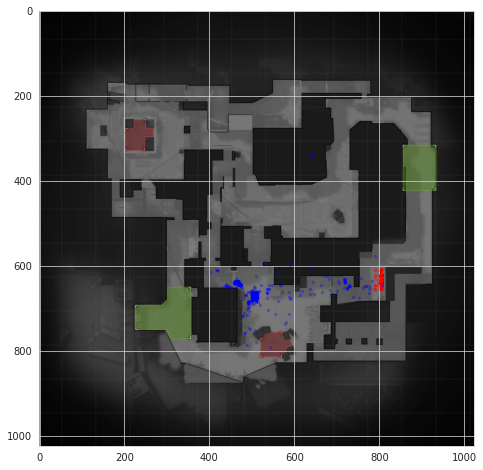

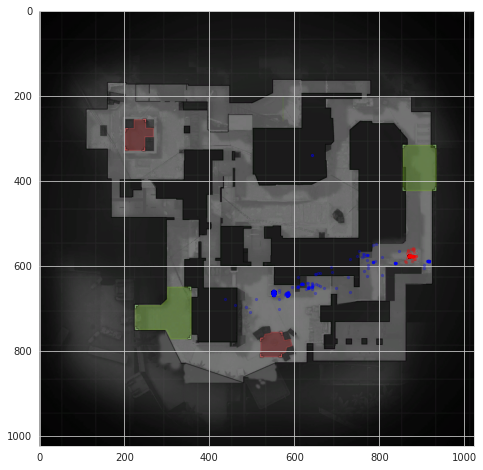

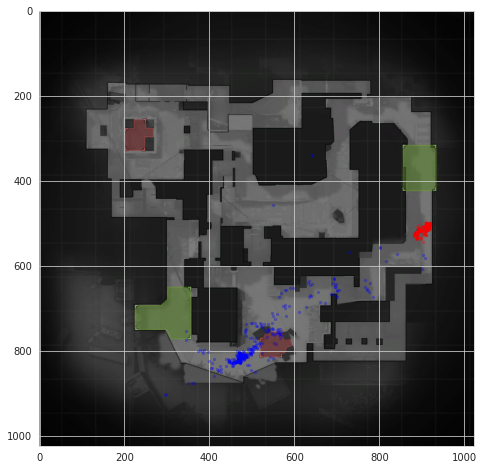

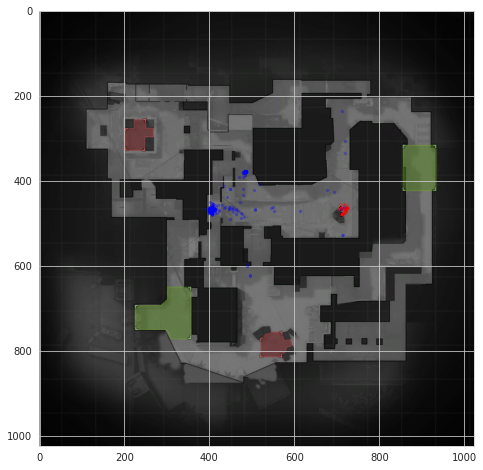

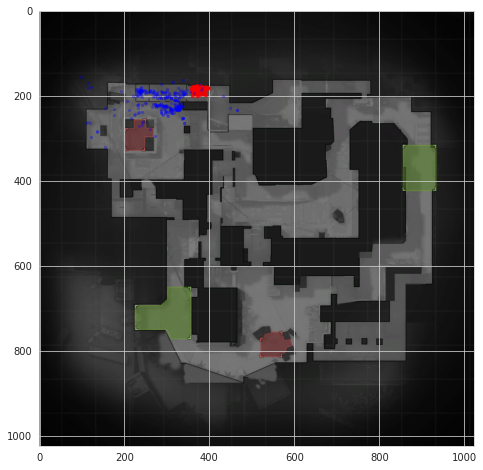

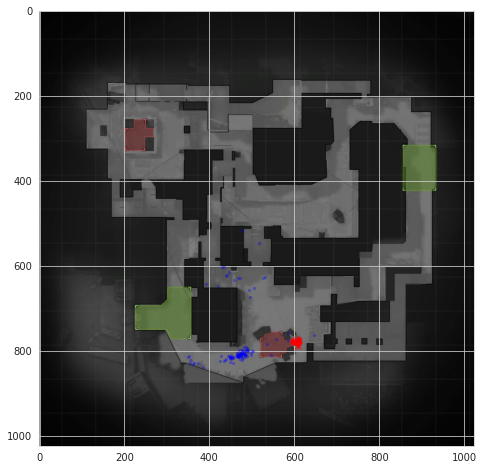

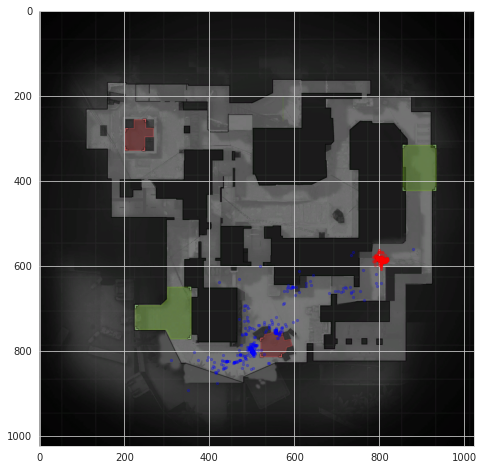

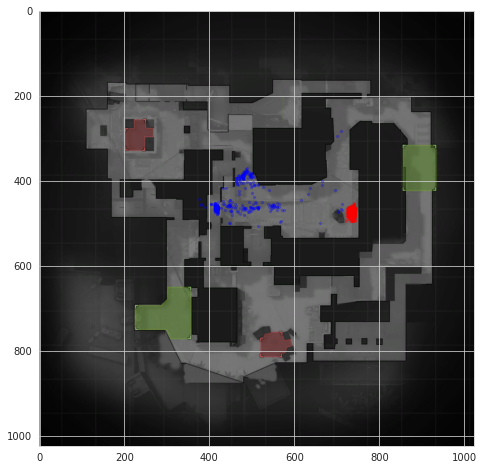

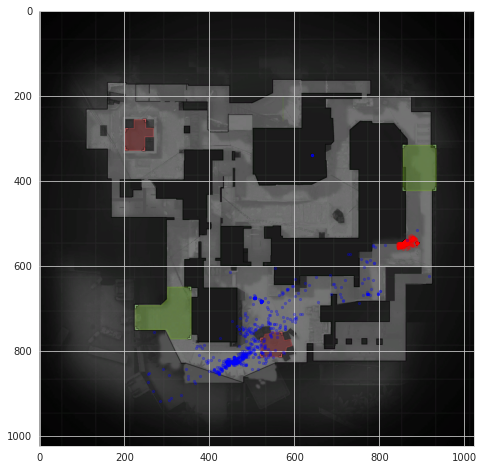

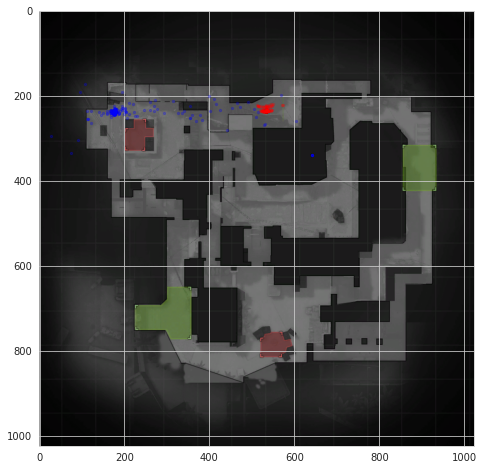

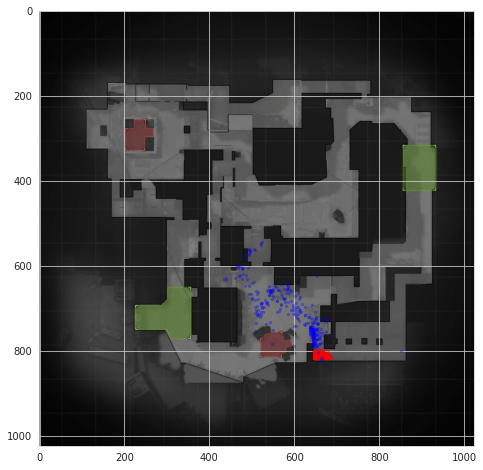

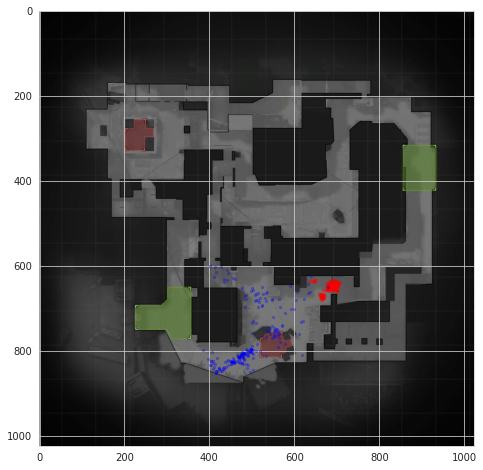

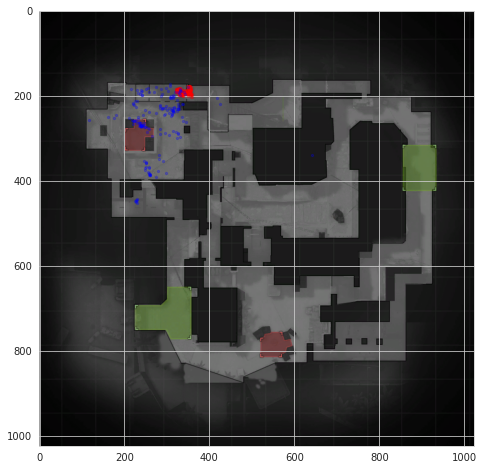

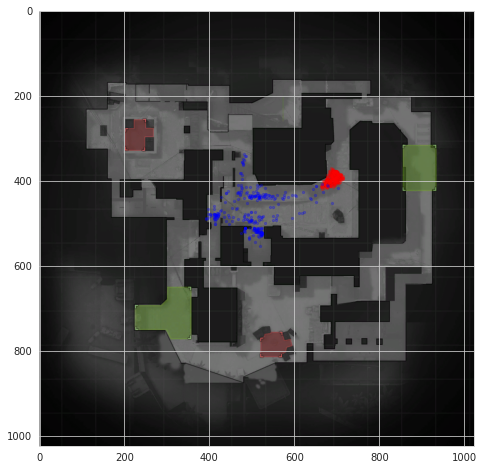

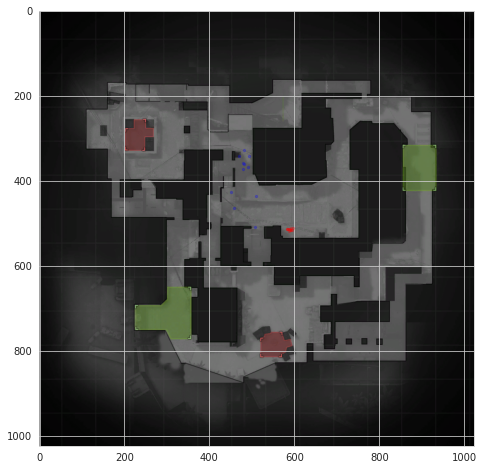

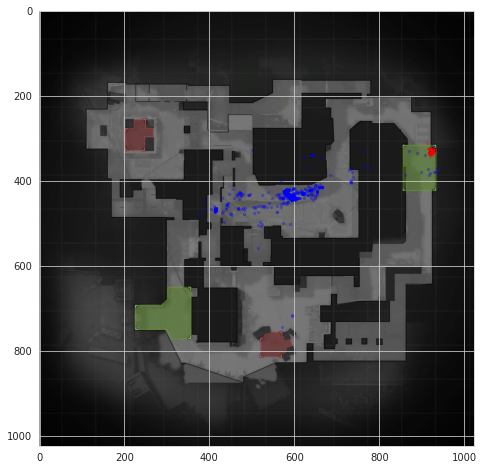

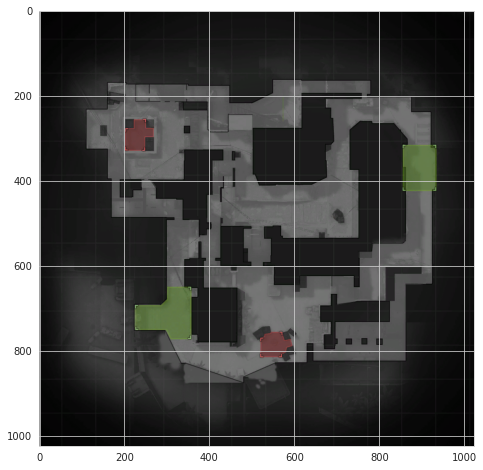

In [22]:
# return_df_unlabel_data takes the same dataframe and the fit kmean model
df_labled_data_df = return_df_unlabel_data(df_density_based_plot_values, k_means_clustering)

# Plot takes it the new labelled data, map and the number of plots for the label clusters which the user wants to see
plot_individual_clusters(df_labled_data_df, 'de_mirage.png', 26)
